In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import random
import re
import itertools
import collections
import networkx as nx
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk import bigrams

In [3]:
access_token = "1351281446988738560-SM9BUh5r834xlAUQf3Lh0fZHUsHQRS"
access_token_secret = "aOPt5nOtQOxzeDrokOwyhP8omH9PQkKglqCXPH2pkgWmf"
consumer_key = "eUuQbttkEBK1t2T4ZkUfgofD2"
consumer_secret = "iBbc9qykHm4UpoFlon7qYc5XPhLl3WvEla9EhCuKAwKBNzFQEn"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [17]:
# Gathering tweets dataset

'''input_queries = ["covidvaccines","scamdemic"]

dataset = []
download_tweet_count = 1000
seen = {}
for input_query in input_queries:
    print(input_query)
    q_dataset = []
    for i, tweet in enumerate(tweepy.Cursor(api.search, q=input_query, lang="en", tweet_mode="extended", 
                                wait_on_rate_limit=True).items()):
        key = tweet.full_text
        if key not in seen:  # this and the following line remove certain types of retweets
            seen[key] = 1

            datum = {
                "topic": input_query,
                "id": tweet.id,

                #user related info
                "username": tweet.author.screen_name,
                "name": tweet.author.name,
                "user_followers_count": tweet.author.followers_count,
                "user_friends_count": tweet.author.friends_count,
                # tweet related information
                "text": tweet.full_text,
                "created_at": tweet.created_at.strftime("%Y-%m-%d %H:%M:%S"),
                "favorite_count": tweet.favorite_count,
                "retweet_count": tweet.retweet_count,                
                # some extracted data from tweet
                "hashtags": ','.join([ht['text'] for ht in tweet.entities['hashtags']]),
                "mentioned_urls": ','.join([url['url'] for url in tweet.entities['urls']]),
                "mentioned_user_ids": ','.join([mention['id_str'] for mention in tweet.entities['user_mentions']]),
                "mentioned_user_names": ','.join([mention['screen_name'] 
                                                  for mention in tweet.entities['user_mentions']]),
            }
            q_dataset += [datum]

        if (i + 1) % 100 == 0:
            print("processed {} tweets: saved {}".format(i + 1, len(q_dataset)))
                  
        if len(q_dataset) >= download_tweet_count:
            break
    dataset += q_dataset
    
dataset2 = [t for t in dataset if "covidvaccine" in t["text"].lower()] + [t for t in dataset if "scamdemic" in t["text"].lower()] 
random.shuffle(dataset2)    
dt = pd.DataFrame.from_dict(dataset)
dt.to_csv('information.csv',index=False)
'''

covidvaccines
processed 100 tweets: saved 67
processed 200 tweets: saved 110
processed 300 tweets: saved 120
processed 400 tweets: saved 145
processed 500 tweets: saved 181
processed 600 tweets: saved 198
processed 700 tweets: saved 223
processed 800 tweets: saved 241
processed 900 tweets: saved 266
processed 1000 tweets: saved 286
processed 1100 tweets: saved 301
processed 1200 tweets: saved 316
processed 1300 tweets: saved 328
processed 1400 tweets: saved 334
processed 1500 tweets: saved 347
processed 1600 tweets: saved 357
processed 1700 tweets: saved 363
processed 1800 tweets: saved 377
processed 1900 tweets: saved 395
processed 2000 tweets: saved 433
processed 2100 tweets: saved 470
processed 2200 tweets: saved 506
processed 2300 tweets: saved 516
processed 2400 tweets: saved 534
processed 2500 tweets: saved 547
processed 2600 tweets: saved 580
processed 2700 tweets: saved 595
processed 2800 tweets: saved 612
processed 2900 tweets: saved 667
processed 3000 tweets: saved 727
proces

In [4]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url

def remove_retweets(txt):
    retweet_pattern = re.compile(r'@*')
    no_retweet = retweet_pattern.sub(r'',txt)
    return no_retweet

In [5]:
dataset = pd.read_csv('information.csv')
information = dataset[dataset['topic'] == 'covidvaccines']
misinformation = dataset[dataset['topic']=='scamdemic']


information_tweets = information['text']
misinformation_tweets = misinformation['text']

# remove urls
information_no_urls = [remove_url(tweet) for tweet in information_tweets]
information_no_urls = [remove_retweets(tweet) for tweet in information_no_urls]
misinformation_no_urls = [remove_url(tweet) for tweet in misinformation_tweets]
misinformation_no_urls = [remove_retweets(tweet) for tweet in misinformation_no_urls]

# Create a sublist of lower case words for each tweet
information_lower = [tweet.lower().split() for tweet in information_no_urls]
misinformation_lower = [tweet.lower().split() for tweet in misinformation_no_urls]

# stop words
stop_words = set(stopwords.words('english'))

# remove stop words
information_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in information_lower]
misinformation_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in misinformation_lower]

# remove collection words
information_collection = ['#covidvaccine','#covidvaccines',
                          '#covidvaccines.','#covid19',
                          '#covidvaccine,','#covid19?',
                          'rt','&amp;']
misinformation_collection = ['#scamdemic','scamdemic','#scamdemic.','rt','&amp;']

information_nsw_nc = [[w for w in word if not w in information_collection]
                 for word in information_nsw]
misinformation_nsw_nc = [[w for w in word if not w in misinformation_collection]
                 for word in misinformation_nsw]


# bigrams
information_bigrams = [list(bigrams(tweet)) for tweet in information_nsw_nc]
misinformation_bigrams = [list(bigrams(tweet)) for tweet in misinformation_nsw_nc]

information_bigrams = list(itertools.chain(*information_bigrams))
misinformation_bigrams = list(itertools.chain(*misinformation_bigrams))

information_bigram_counts = collections.Counter(information_bigrams)
misinformation_bigram_counts = collections.Counter(misinformation_bigrams)

information_bigram_df = pd.DataFrame(information_bigram_counts.most_common(30),
                             columns=['bigram', 'count'])
misinformation_bigram_df = pd.DataFrame(misinformation_bigram_counts.most_common(30),
                             columns=['bigram', 'count'])



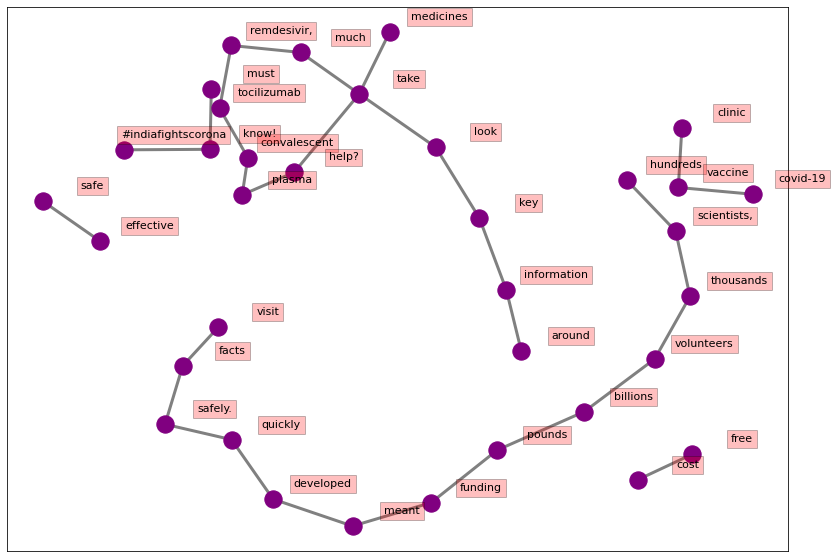

In [17]:
information_dict = information_bigram_df.set_index('bigram').T.to_dict('records')

information_graph = nx.Graph()

# Create connections between nodes
for k, v in information_dict[0].items():
    information_graph.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(14, 10))

pos = nx.spring_layout(information_graph, k=2)

# Plot networks
nx.draw_networkx(information_graph, pos,
                 font_size=13,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=11)
    
plt.show()

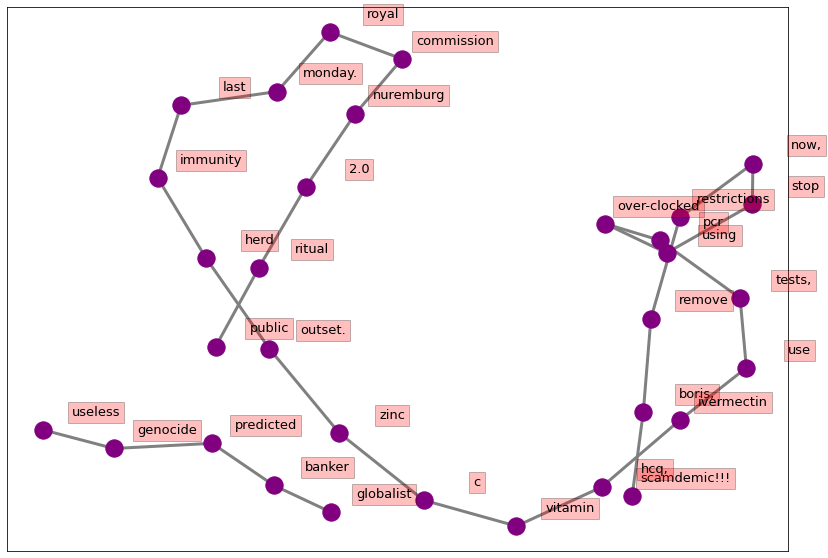

In [11]:
misinformation_dict = misinformation_bigram_df.set_index('bigram').T.to_dict('records')

misinformation_graph = nx.Graph()

# Create connections between nodes
for k, v in misinformation_dict[0].items():
    misinformation_graph.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(14, 10))

pos = nx.spring_layout(misinformation_graph, k=2)

# Plot networks
nx.draw_networkx(misinformation_graph, pos,
                 font_size=13,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()